In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

env: CUDA_VISIBLE_DEVICES=[]


### Picidae vocalizations
- source: https://zenodo.org/record/574438#.XOnxJ9NKhTY
- /mnt/cube/Datasets/Picidae/PicidaeDataset
        

In [2]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn.signalprocessing import spectrogramming as sg
from avgn.utils.general import HParams

### data locations

In [4]:
DSLOC = Path('/mnt/cube/Datasets/Picidae/PicidaeDataset/')
readme = DSLOC/'Read Me'
readme = [line for line in open(readme, 'r')]  

### make wav dataset

In [5]:
all_wavs = list(DSLOC.expanduser().glob('*/*.wav'))
all_wavs = [i for i in all_wavs if i.stem[0] != '.']
len(all_wavs)

1669

In [6]:
all_wavs[:3]

[PosixPath('/mnt/cube/Datasets/Picidae/PicidaeDataset/PicusViridis-song/XC252476-PicusViridis-song-1.wav'),
 PosixPath('/mnt/cube/Datasets/Picidae/PicidaeDataset/PicusViridis-song/XC281262-PicusViridis-song-3.wav'),
 PosixPath('/mnt/cube/Datasets/Picidae/PicidaeDataset/PicusViridis-song/XC281263-PicusViridis-song-1.wav')]

In [7]:
wav_df = pd.DataFrame(columns = ['species', 'call_type', 'wavloc', 'rate', 'audiodata', 'length', 'origin'])
for wav_loc in tqdm(all_wavs):
    if wav_loc.parent.stem == 'Silence': continue
    rate, data = load_wav(wav_loc)
    species, call_type = wav_loc.parent.stem.split('-')
    wav_df.loc[len(wav_df)] = [species, call_type, wav_loc, rate, data, len(data)/rate,  wav_loc.stem.split('-')[0]]

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [8]:
 wav_loc.stem.split('-')[0]

'XC329955'

In [9]:
wav_df[:3]

,species,call_type,wavloc,rate,audiodata,length,origin
0,PicusViridis,song,/mnt/cube/Datasets/Picidae/PicidaeDataset/Picu...,44100,"[-138, -120, -74, 22, 105, 46, -22, 8, 28, 72,...",4.0,XC252476
1,PicusViridis,song,/mnt/cube/Datasets/Picidae/PicidaeDataset/Picu...,44100,"[-494, -580, -392, 15, 435, 638, 515, 156, -22...",2.5,XC281262
2,PicusViridis,song,/mnt/cube/Datasets/Picidae/PicidaeDataset/Picu...,44100,"[353, 198, 14, -166, -306, -389, -431, -455, -...",2.5,XC281263


In [13]:
wav_df.call_type.unique()

array(['song', 'call', 'drumming'], dtype=object)

In [ ]:
wav_df.species.unique()

In [11]:
wav_df.species.unique()

array(['PicusViridis', 'DryocopusMartius', 'DendrocoposMedius',
       'JynxTorquilla', 'DendrocoposLeucotos', 'DendrocoposMinor',
       'DendrocoposMajor'], dtype=object)

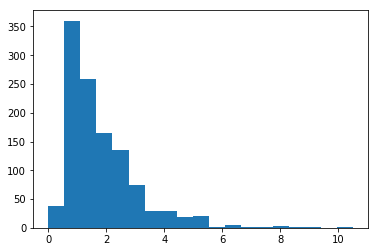

In [15]:
plt.hist(wav_df.length.values, bins=np.linspace(0, np.max(wav_df.length.values), 20));

### make spectrograms

In [16]:
win_length_ms = 10
hop_length_ms = 2
print(win_length_ms / 1000 * rate)
print(hop_length_ms / 1000 * rate)

hparams = HParams(
    # spectrogramming
    win_length=int(rate / 1000 * win_length_ms),
    n_fft=4800,
    hop_length=int(rate / 1000 * hop_length_ms),
    ref_level_db=20,
    min_level_db=-50,
    preemphasis=0.97,
    # mel scaling
    num_mel_bins=128,
    mel_lower_edge_hertz=1000,
    mel_upper_edge_hertz=rate/2,
    # inversion
    power=1.5,  # for spectral inversion
    griffin_lim_iters=50,
    pad=True,
    #
)

441.0
88.2


In [17]:
import IPython

In [18]:
row = wav_df[wav_df.call_type=='song'].iloc[45]
row

species                                           PicusViridis
call_type                                                 song
wavloc       /mnt/cube/Datasets/Picidae/PicidaeDataset/Picu...
rate                                                     44100
audiodata    [45, -146, -289, -36, -296, -241, -113, 3, 263...
length                                                       2
origin                                                XC354361
Name: 45, dtype: object

In [19]:
audio = int16_to_float32(row.audiodata)
spectrogram = sg.spectrogram(audio, hparams)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


In [20]:
IPython.display.Audio(data=audio, rate=rate)

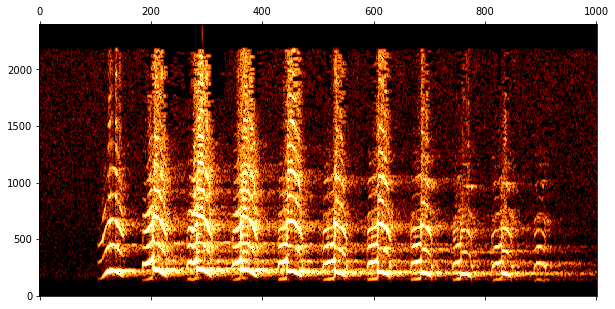

In [21]:
fig, ax = plt.subplots(figsize=(10,5))
ax.matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
#ax.axis('off')

In [22]:
np.min(spectrogram/(np.mean(spectrogram, axis=1)+1e-4)[:,None])

0.0

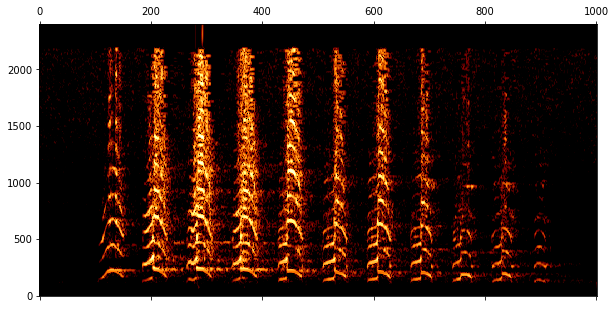

In [23]:
x = spectrogram-(np.mean(spectrogram, axis=1))[:,None]
x[x<0] = 0
fig, ax = plt.subplots(figsize=(10,5))
ax.matshow(x, origin='lower', aspect='auto', cmap = plt.cm.afmhot)

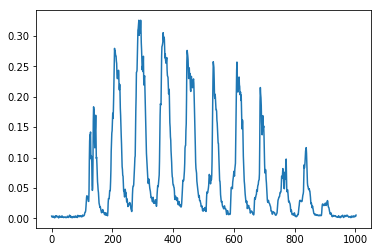

In [24]:
plt.plot(np.mean(x, axis=0))

### view song by species

In [25]:
nrow = 3
ncol = 3
zoom = 2

call
	DendrocoposLeucotos


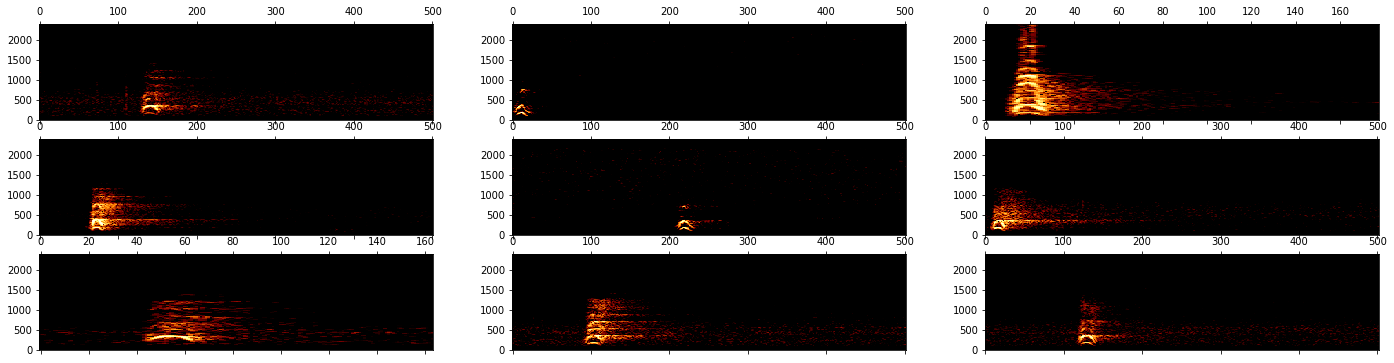

	DendrocoposMajor


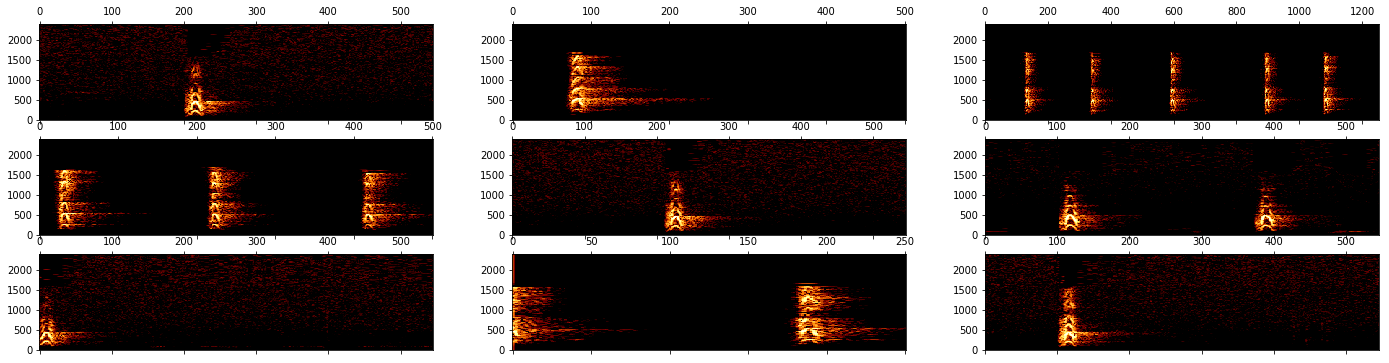

	DendrocoposMedius


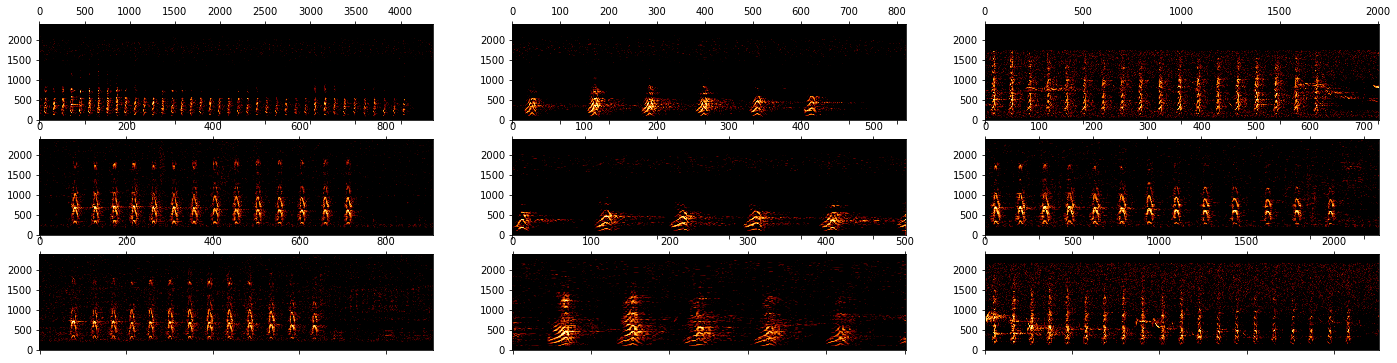

	DendrocoposMinor


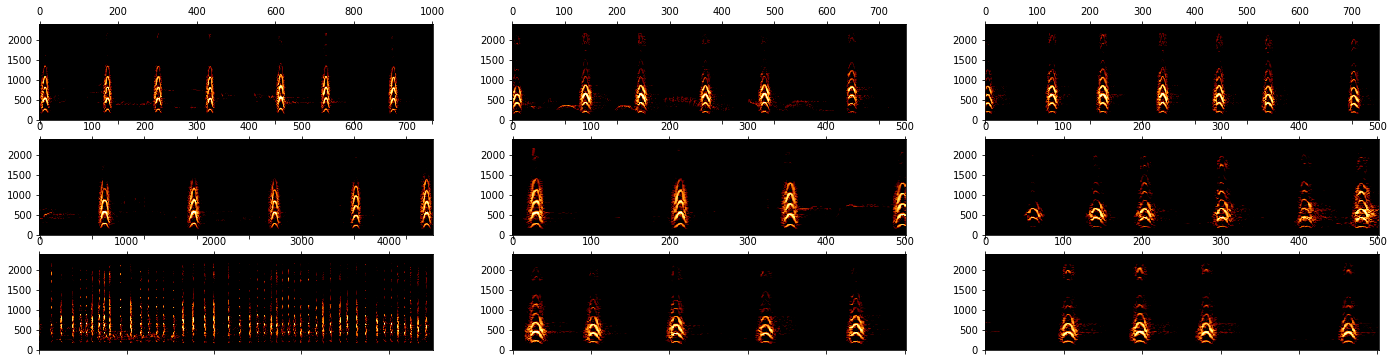

	DryocopusMartius


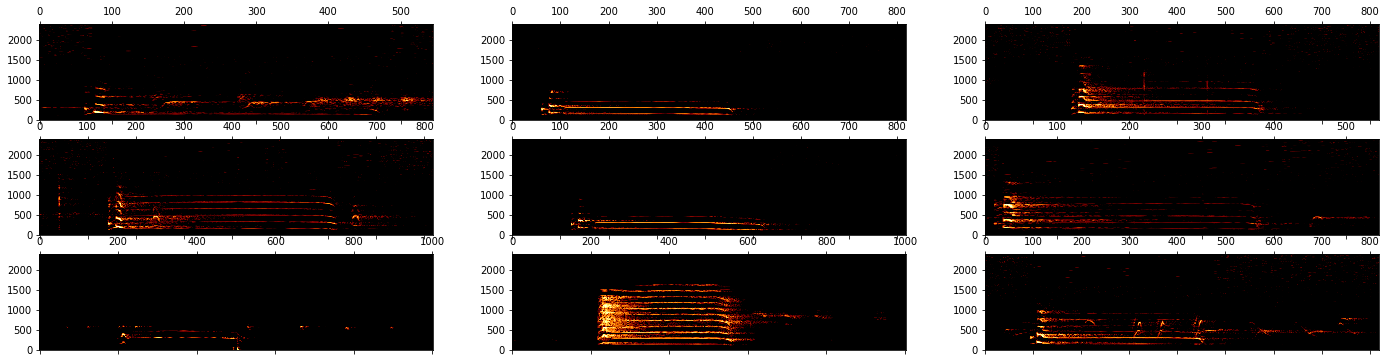

drumming
	DendrocoposLeucotos


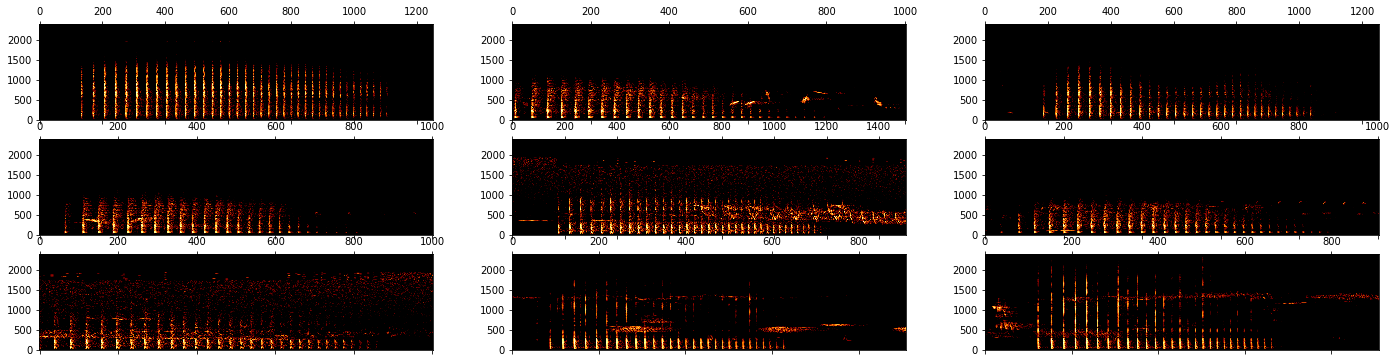

	DendrocoposMajor


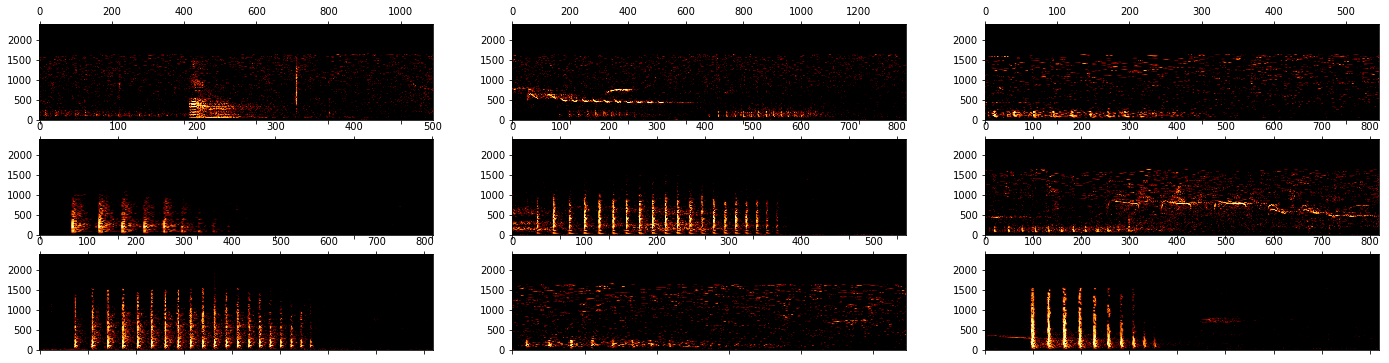

	DendrocoposMinor


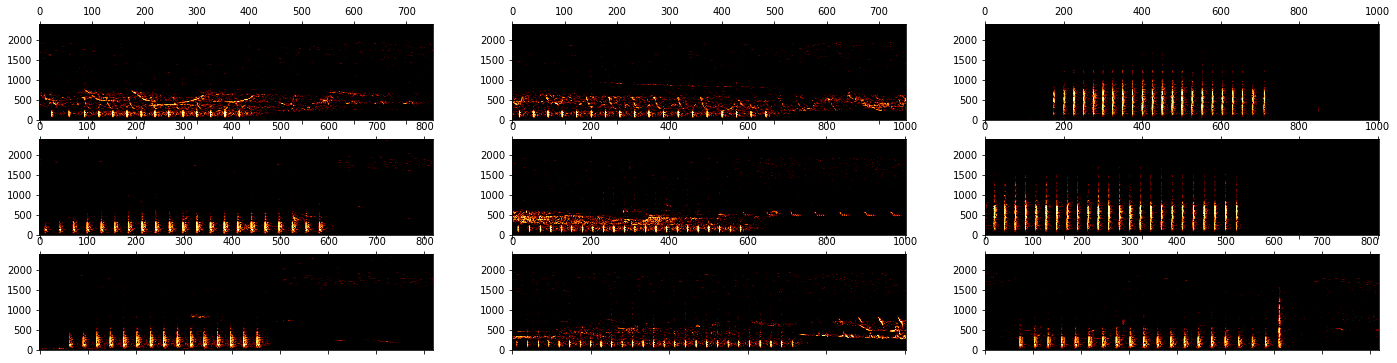

	DryocopusMartius


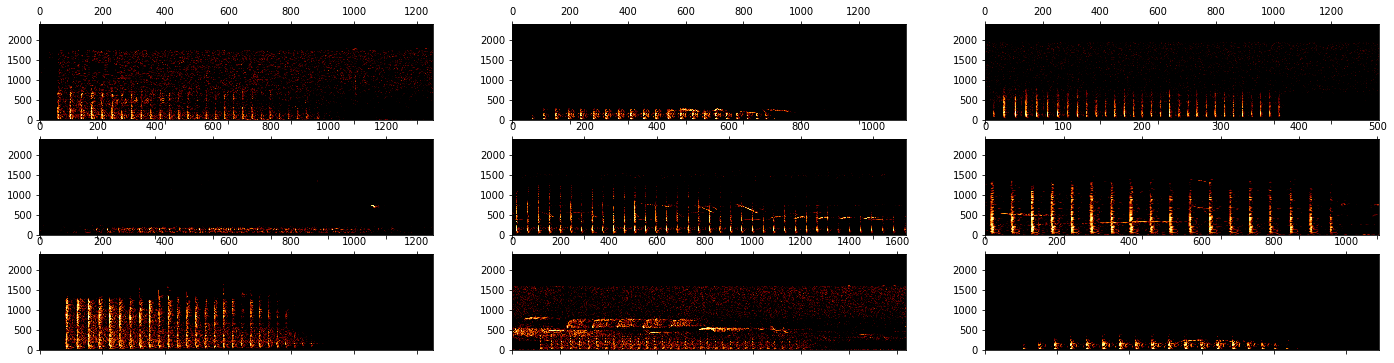

song
	DendrocoposMedius


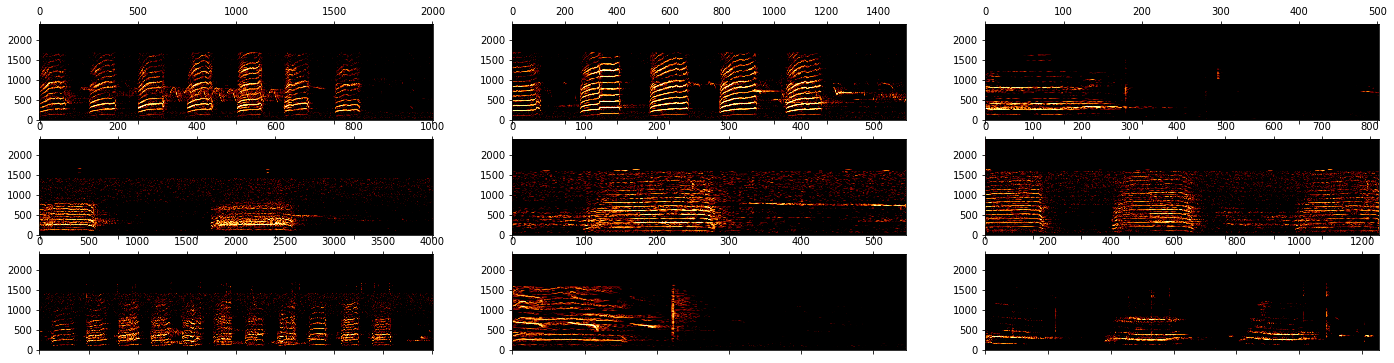

	JynxTorquilla


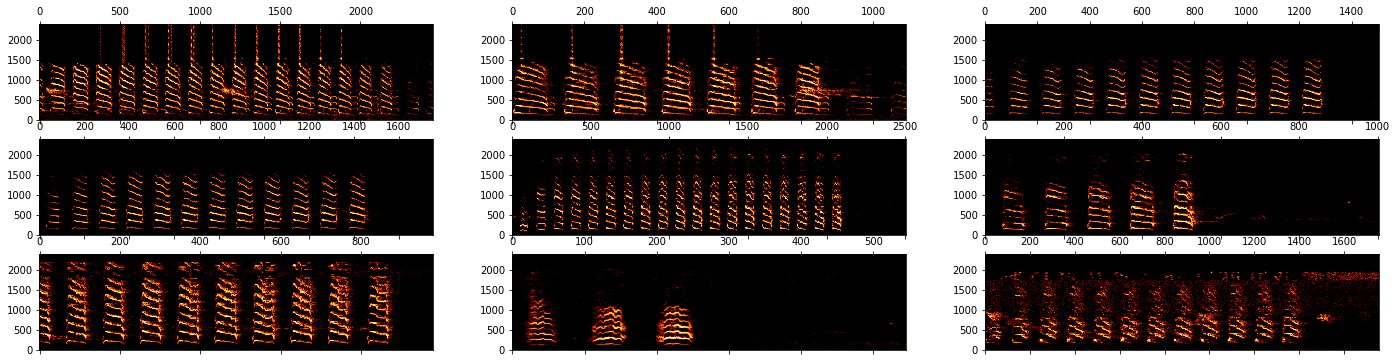

	PicusViridis


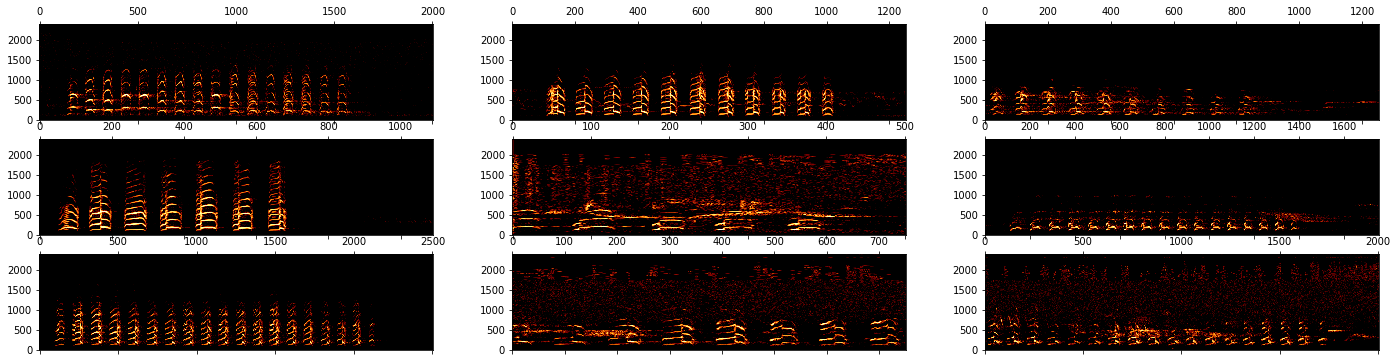

In [26]:
for call_type in np.unique(wav_df.call_type):
    print(call_type)
    call_df = wav_df[wav_df.call_type == call_type]
    for species in np.unique(call_df.species):
        species_df = call_df[call_df.species == species]
        print('\t'+species)
        fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*zoom*4, nrow*zoom))
        for rowix, (idx, row) in enumerate(species_df[:nrow*ncol].iterrows()):
            ax = axs.flatten()[rowix]
            # get audio
            audio = int16_to_float32(row.audiodata)
            spectrogram = sg.spectrogram(audio, hparams)
            # norm
            x = spectrogram-(np.mean(spectrogram, axis=1))[:,None]
            x[x<0] = 0
            # plot
            ax.matshow(x, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
        plt.show()

In [290]:
species_df[:3]

,species,call_type,wavloc,rate,audiodata,length
0,PicusViridis,song,/mnt/cube/Datasets/Picidae/PicidaeDataset/Picu...,44100,"[-138, -120, -74, 22, 105, 46, -22, 8, 28, 72,...",4.0
1,PicusViridis,song,/mnt/cube/Datasets/Picidae/PicidaeDataset/Picu...,44100,"[-494, -580, -392, 15, 435, 638, 515, 156, -22...",2.5
2,PicusViridis,song,/mnt/cube/Datasets/Picidae/PicidaeDataset/Picu...,44100,"[353, 198, 14, -166, -306, -389, -431, -455, -...",2.5
